# **_KKBox Customer Churn Prediction -- Big Data Project -- Group 5_**


**Synopsis**:

KKBOX is Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. They offer a generous, unlimited version of their service to millions of people, supported by advertising and paid subscriptions. This delicate model is dependent on accurately predicting churn of their paid users.In this project we aim to predict the customer churn and find out interesting insights and suggestions to reduce the churn

**Reference and Data Source**: https://www.kaggle.com/c/kkbox-churn-prediction-challenge

**Data Description**
Source : Kaggle

1. train_v2.csv
    the train set, containing the user ids and whether they have churned.
        msno: user id
        is_churn: target, is_churn = 1 means churn,is_churn = 0 means renewal.

2. transactions_v2.csv
        msno: user id
        payment_method_id: payment method
        payment_plan_days: length of membership plan in days
        plan_list_price: in New Taiwan Dollar (NTD)
        actual_amount_paid: in New Taiwan Dollar (NTD)
        is_auto_renew
        transaction_date: format %Y%m%d
        membership_expire_date: format %Y%m%d
        is_cancel: whether or not the user canceled the membership in this transaction.
        
3. user_logs_v2.csv
    daily user logs describing listening behaviors of a user.
        msno: user id
        date: format %Y%m%d
        num_25: # of songs played less than 25% of the song length
        num_50: # of songs played between 25% to 50% of the song length
        num_75: # of songs played between 50% to 75% of of the song length
        num_985: # of songs played between 75% to 98.5% of the song length
        num_100: # of songs played over 98.5% of the song length
        num_unq: # of unique songs played
        total_secs: total seconds played
        
4. members_v3.csv
    user information:
        msno
        city
        bd: age
        gender
        registered_via: registration method
        registration_init_time: format %Y%m%d
        expiration_date: format %Y%m%d


## **Data Cleaning **

In [1]:
#Import the necessary libraries

from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql import functions
from pyspark.sql.functions import isnan, when, count, col
import pandas as pd
import numpy as np
import matplotlib.pyplot as mplt
import matplotlib.ticker as mtick
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler, OneHotEncoderEstimator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
#Create Spark Session
spark = SparkSession\
  .builder\
  .appName("KKBox Customer Churn Prediction")\
  .getOrCreate()
    
spark.version

u'2.4.0'

In [3]:
#Load the data
user_log_schema=StructType([
        StructField("msno",StringType(),False),
        StructField("date",StringType(),False),
        StructField("num_25",IntegerType(),False),
        StructField("num_50",IntegerType(),False),
        StructField("num_985",IntegerType(),False),
        StructField("num_100",IntegerType(),False),
        StructField("num_unq",IntegerType(),False),
        StructField("total_secs",DoubleType(),False)       
    ])
#train is used for target variables 
train=spark.read.csv("hdfs://quickstart.cloudera:8020///user/cloudera/data/train_v2.csv",header=True,sep=",")
#members information
members=spark.read.csv("hdfs://quickstart.cloudera:8020/user/cloudera/data/members_v3.csv",header=True,sep=",") 
#information on transactions
transactions=spark.read.csv("hdfs://quickstart.cloudera:8020/user/cloudera/data/transactions_v2.csv",header=True,sep=",") 
#logs of users
user_logs=spark.read.csv("hdfs://quickstart.cloudera:8020/user/cloudera/data/user_logs_v2.csv",header=True,sep=",",schema=user_log_schema)

#Reference: https://www.linkedin.com/pulse/get-your-hands-on-pyspark-solve-kaggle-problems-majid-bahrepour-phd/

In [4]:
#Understanding the user logs
user_logs.show()

+--------------------+--------+------+------+-------+-------+-------+----------+
|                msno|    date|num_25|num_50|num_985|num_100|num_unq|total_secs|
+--------------------+--------+------+------+-------+-------+-------+----------+
|u9E91QDTvHLq6NXjE...|20170331|     8|     4|      0|      1|     21|      18.0|
|nTeWW/eOZA/UHKdD5...|20170330|     2|     2|      1|      0|      9|      11.0|
|2UqkWXwZbIjs03dHL...|20170331|    52|     3|      5|      3|     84|     110.0|
|ycwLc+m2O0a85jSLA...|20170331|   176|     4|      2|      2|     19|     191.0|
|EGcbTofOSOkMmQyN1...|20170331|     2|     1|      0|      1|    112|      93.0|
|qR/ndQ5B+1cY+c9ih...|20170331|     3|     0|      0|      0|     39|      41.0|
|N6ch5ArfJixq9mvAR...|20170330|     9|     1|      0|      0|     18|      26.0|
|JEjl2W1ivEI6epeob...|20170331|   181|    68|      5|      3|     54|     291.0|
|lPK4IYIFdfTT6pq7x...|20170331|     3|     0|      1|      1|    181|     150.0|
|cDgnvwQwCwru2m3zc...|201703

User Logs consists of the details on the number of songs heard by the user, we further aggregate the song statistics
in order to find the aggregate song statistics per user.
We are interested in finding whether the songs heard only for 25% of the duration and 100% of the duration have impact on the customer churn


In [5]:
#find aggregate statistics
agg_user_logs=user_logs.groupBy('msno').agg(count("msno").alias('no_transactions'),
                                 sum('num_25').alias('Total25'),sum('num_100').alias('Total100'), mean('num_unq').alias('UniqueSongs'),mean('total_secs').alias('TotalSecHeard')
                               )

agg_user_logs.show()

+--------------------+---------------+-------+--------+------------------+------------------+
|                msno|no_transactions|Total25|Total100|       UniqueSongs|     TotalSecHeard|
+--------------------+---------------+-------+--------+------------------+------------------+
|qufKUjlo3SOny5C/6...|             20|      4|       8|             74.45|              28.7|
|ORUaiH4z66kfVaKGv...|             25|     66|      44|             74.04|             62.56|
|43522HpkDYxZI7k9V...|             25|     72|       4|             23.72|              22.0|
|nSmTz9Kn4H6Ij9rvI...|             30|    725|     425| 50.13333333333333| 72.86666666666666|
|met2zqqAa6vxyrybR...|             31|    344|      40| 37.70967741935484| 37.58064516129032|
|kqgPQ80WF4perwl37...|             27|    242|      57|              73.0| 62.18518518518518|
|lYI3D0HD5vpAMG10z...|             13|     27|       6| 66.53846153846153|              33.0|
|rmLyFqnpTGWuJ/XRL...|             27|    107|     102|13.14

In the dataset, we have two important features namely: membership_expire_date and registration_init_time. In order to consider the impact of the number of days that the user was on board right after registering , we found out the derived variable namely "DaysOnBoard" from these two features.

In [6]:
#Merging the datasets

data = agg_user_logs.join(transactions,"msno").join(train,"msno").join(members, "msno")

#Data format conversion

data =  data.withColumn("payment_method_id", data["payment_method_id"].cast("integer"))
data =  data.withColumn("payment_plan_days", data["payment_plan_days"].cast("integer"))
data =  data.withColumn("plan_list_price", data["plan_list_price"].cast("integer"))
data =  data.withColumn("actual_amount_paid", data["actual_amount_paid"].cast("integer"))
data =  data.withColumn("is_auto_renew", data["is_auto_renew"].cast("integer"))
data =  data.withColumn("transaction_date",date_format(from_unixtime(unix_timestamp('transaction_date', 'yyyyMMdd')),'yyyy-MM-dd').alias("transaction_date"))
data =  data.withColumn("membership_expire_date",date_format(from_unixtime(unix_timestamp('membership_expire_date', 'yyyyMMdd')),'yyyy-MM-dd').alias("membership_expire_date"))
data =  data.withColumn("registration_init_time",date_format(from_unixtime(unix_timestamp('registration_init_time', 'yyyyMMdd')),'yyyy-MM-dd').alias("registration_init_time"))
data =  data.withColumn("is_cancel", data["is_cancel"].cast("integer"))
data =  data.withColumn("is_churn", data["is_churn"].cast("integer"))
data =  data.withColumn("bd", data["bd"].cast("integer"))
data =  data.withColumn("registered_via", data["registered_via"].cast("integer"))
data =  data.withColumn("DaysOnBoard",datediff(data['membership_expire_date'],data['registration_init_time']))

data.show()

+--------------------+---------------+-------+--------+------------------+------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+--------+----+---+------+--------------+----------------------+-----------+
|                msno|no_transactions|Total25|Total100|       UniqueSongs|     TotalSecHeard|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|is_churn|city| bd|gender|registered_via|registration_init_time|DaysOnBoard|
+--------------------+---------------+-------+--------+------------------+------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+--------+----+---+------+--------------+----------------------+-----------+
|++4RuqBw0Ss6bQU4o...|              1|     14|       0|               9.0|              

In [24]:
data.select("bd").where("bd > 100").show(2)

+---+
| bd|
+---+
|112|
|101|
+---+
only showing top 2 rows



In [7]:
# As per the data description and the dataframe results above, we need to remove age outliers.
churn_data = data.where("bd between 15 and 100")

In [26]:
#Identify if we have nulls in the dataset
churn_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in churn_data.columns]).show()

+----+---------------+-------+--------+-----------+-------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+--------+----+---+------+--------------+----------------------+-----------+
|msno|no_transactions|Total25|Total100|UniqueSongs|TotalSecHeard|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|is_churn|city| bd|gender|registered_via|registration_init_time|DaysOnBoard|
+----+---------------+-------+--------+-----------+-------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+--------+----+---+------+--------------+----------------------+-----------+
|   0|              0|      0|       0|          0|            0|                0|                0|              0|                 0|            0|               0|     

We can see that there are significant number of nulls in the gender column, addressing this issue by filling the nulls with "NA".
It can also be seen that the significant number of users did not reveal their age.

In [8]:
colNames = ["gender"]
churn_data = churn_data.na.fill("NA", colNames)

#Verify if we have removed the nulls
churn_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in churn_data.columns]).show()

+----+---------------+-------+--------+-----------+-------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+--------+----+---+------+--------------+----------------------+-----------+
|msno|no_transactions|Total25|Total100|UniqueSongs|TotalSecHeard|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|is_churn|city| bd|gender|registered_via|registration_init_time|DaysOnBoard|
+----+---------------+-------+--------+-----------+-------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+--------+----+---+------+--------------+----------------------+-----------+
|   0|              0|      0|       0|          0|            0|                0|                0|              0|                 0|            0|               0|     

## Feature Selection

In [9]:
#Find the correlation between the independent variables
features = churn_data.select("Total25","Total100","UniqueSongs","TotalSecHeard","payment_plan_days","plan_list_price","actual_amount_paid","DaysOnBoard","bd")
features1=features.rdd.map(lambda x: x[0:])
corr_mat=Statistics.corr(features1, method="pearson")
corr_df = pd.DataFrame(corr_mat)

corr_df.index = ("Total25","Total100","UniqueSongs","TotalSecHeard","payment_plan_days","plan_list_price","actual_amount_paid","DaysOnBoard","bd")
corr_df.columns= ("Total25","Total100","UniqueSongs","TotalSecHeard","payment_plan_days","plan_list_price","actual_amount_paid","DaysOnBoard","bd")

print(corr_df.to_string())

                     Total25  Total100  UniqueSongs  TotalSecHeard  payment_plan_days  plan_list_price  actual_amount_paid  DaysOnBoard        bd
Total25             1.000000  0.360093     0.125786       0.415742           0.024959         0.022536            0.022623    -0.063588 -0.132160
Total100            0.360093  1.000000     0.204415       0.323647           0.016190         0.017449            0.017816    -0.029262 -0.090366
UniqueSongs         0.125786  0.204415     1.000000       0.793036           0.013891         0.015785            0.015807    -0.002556 -0.000752
TotalSecHeard       0.415742  0.323647     0.793036       1.000000           0.027252         0.025453            0.025431    -0.024865 -0.061943
payment_plan_days   0.024959  0.016190     0.013891       0.027252           1.000000         0.950819            0.948974    -0.015572 -0.048065
plan_list_price     0.022536  0.017449     0.015785       0.025453           0.950819         1.000000            0.997051  

It can be seen that there is a strong correlation between plan_list_price and actual_amount_paid. In order to overcome this scenario we further derive another variable namely Discount which is the difference between what the user actually paid from the listed price. We want to further analyze whether this has any impact on the churning.

In [10]:
#Find out if there was a discount provided to the user
churn_data = churn_data.withColumn("Discount", churn_data['actual_amount_paid']-churn_data['plan_list_price'])
churn_data.where("Discount > 0").show()

#dropping unrequired columns: 
columns_to_drop = ['membership_expire_date', 'registration_init_time', 'actual_amount_paid', 'plan_list_price' ]
churn_data = churn_data.drop(*columns_to_drop)


+--------------------+---------------+-------+--------+------------------+------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+--------+----+---+------+--------------+----------------------+-----------+--------+
|                msno|no_transactions|Total25|Total100|       UniqueSongs|     TotalSecHeard|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|is_churn|city| bd|gender|registered_via|registration_init_time|DaysOnBoard|Discount|
+--------------------+---------------+-------+--------+------------------+------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+--------+----+---+------+--------------+----------------------+-----------+--------+
|z8bjSNtBJlL1ApYmO...|             27|    312|      63|      

In [31]:
#Data after cleaning and feature selection
churn_data.describe()

DataFrame[summary: string, msno: string, no_transactions: string, Total25: string, Total100: string, UniqueSongs: string, TotalSecHeard: string, payment_method_id: string, payment_plan_days: string, is_auto_renew: string, transaction_date: string, is_cancel: string, is_churn: string, city: string, bd: string, gender: string, registered_via: string, DaysOnBoard: string, Discount: string]

### Feature Visualization

We want to understand the frequency of our target variable: is_churn and the derviced variables namely Discount and daysOnBoard.

In [32]:
#Function to plot the histograms
def plotHistogramData(data, xlabel = "Bins", ylabel ="Frequencies"):
    binSides, binCounts = data

    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = mplt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title('Histogram')
    ax.set_xticks(np.arange(N+1))
    ax.set_xticklabels(binSides)
    mplt.show()
    

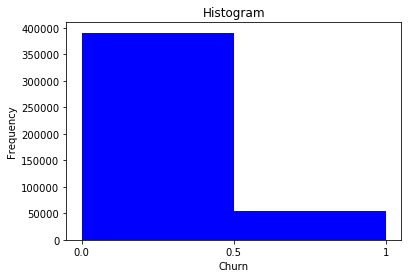

In [33]:
data = churn_data.select('is_churn').rdd.flatMap(lambda x: x).histogram(2)
plotHistogramData(data, "Churn", "Frequency")

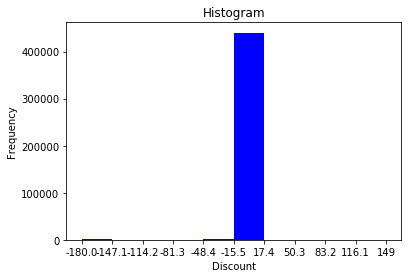

In [38]:
data = churn_data.select('Discount').rdd.flatMap(lambda x: x).histogram(10)
plotHistogramData(data, "Discount", "Frequency")

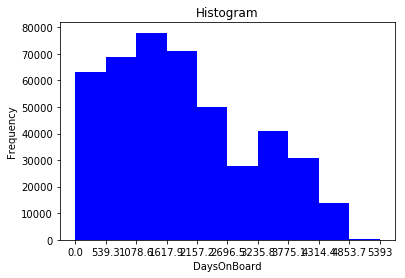

In [35]:
data = churn_data.select('DaysOnBoard').rdd.flatMap(lambda x: x).histogram(10)
plotHistogramData(data, "DaysOnBoard", "Frequency")

We can see from the histograms that our target variable is skewed while the DaysOnBoard is indicating that the there is high variance with the regards to the duration that the users subscribe to the KKBox services. While the doscount indicates that not much discount is being provided to the users

Let us visualize the impact of some of the features on the customer churn

In [39]:
#Using Pyspark ml crosstab functionality
churn_data.stat.crosstab("is_churn", "Discount").show()

+-----------------+---+----+----+----+---+---+---+---+------+---+---+---+---+---+
|is_churn_Discount| -1|-129|-149|-180|-20|-30|-50|-99|     0|  1|100|119|129|149|
+-----------------+---+----+----+----+---+---+---+---+------+---+---+---+---+---+
|                1|  0|   2| 476| 720| 15| 70| 28|  1| 52234| 46|  0|  9|  2| 26|
|                0|  1|   1| 133|1385|150|625|396|  2|387748|  0|  2| 56| 33|314|
+-----------------+---+----+----+----+---+---+---+---+------+---+---+---+---+---+



In [42]:
churn_data.stat.crosstab("is_churn", "gender").show()

+---------------+----+------+------+
|is_churn_gender|  NA|female|  male|
+---------------+----+------+------+
|              1|3878| 23802| 25949|
|              0|8358|181980|200508|
+---------------+----+------+------+



In [47]:
churn_data.stat.crosstab("is_churn", "is_cancel").show()

+------------------+------+----+
|is_churn_is_cancel|     0|   1|
+------------------+------+----+
|                 1| 47519|6110|
|                 0|384886|5960|
+------------------+------+----+



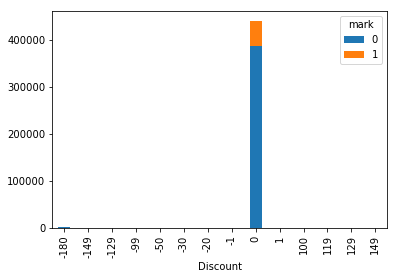

In [44]:
#Using pandas to visualize 
churn_EDA = churn_data.toPandas()
crosstabPD=pd.crosstab(churn_EDA['Discount'],churn_EDA['is_churn'])
crosstabPD.plot.bar(stacked = True)
mplt.legend(title='mark')
mplt.show()


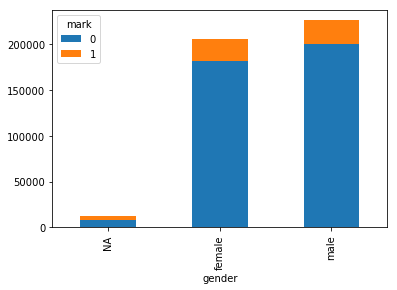

In [45]:
crosstabPD=pd.crosstab(churn_EDA['gender'],churn_EDA['is_churn'])
crosstabPD.plot.bar(stacked = True)
mplt.legend(title='mark')
mplt.show()

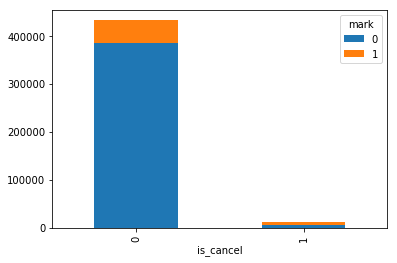

In [46]:
crosstabPD=pd.crosstab(churn_EDA['is_cancel'],churn_EDA['is_churn'])
crosstabPD.plot.bar(stacked = True)
mplt.legend(title='mark')
mplt.show()

## Feature Importance

In order to calculate and select the final variables for our analysis we use the GeneralizedLinearRegression to calculate the Pvalues and select the important features

In [11]:
# Constructing the features as aspected by the Models

#Handle gender categorical variable:
gender_index=StringIndexer().setInputCol("gender").setOutputCol("gender_indexed")
# transform
churn_data=gender_index.fit(churn_data).transform(churn_data)
#we are only interested in the indexed gender
churn_data = churn_data.drop("gender")

churn_data.describe()

DataFrame[summary: string, msno: string, no_transactions: string, Total25: string, Total100: string, UniqueSongs: string, TotalSecHeard: string, payment_method_id: string, payment_plan_days: string, is_auto_renew: string, transaction_date: string, is_cancel: string, is_churn: string, city: string, bd: string, registered_via: string, DaysOnBoard: string, Discount: string, gender_indexed: string]

In [12]:
assembler=VectorAssembler(inputCols=[ 'no_transactions', 'Total25', 'Total100', 'UniqueSongs', 'TotalSecHeard', 'payment_method_id', 'payment_plan_days', 'is_auto_renew',  'is_cancel', 'bd',  'registered_via', 'DaysOnBoard', 'Discount', "gender_indexed"],outputCol='features')
churn_data=assembler.transform(churn_data)
churn_data.select("features").show(2)

+--------------------+
|            features|
+--------------------+
|[23.0,970.0,20.0,...|
|[30.0,345.0,31.0,...|
+--------------------+
only showing top 2 rows



In [13]:
#Spliting the data into 70:30 
splits=churn_data.randomSplit([0.7 , 0.3])
train=splits[0]
test=splits[1]

In [14]:
#Running the Generalized Resgression to get the p-values
rf=GeneralizedLinearRegression(labelCol='is_churn',featuresCol='features',maxIter=10,regParam=0.3)
lrModel = rf.fit(train)

In [22]:
#Understanding and visualizing the pvalues
pd.set_option('display.max_colwidth', 30)

feature_names = ['intercept', 'no_transactions', 'Total25', 'Total100', 'UniqueSongs', 'TotalSecHeard', 'payment_method_id', 'payment_plan_days', 'is_auto_renew',  'is_cancel', 'bd',  'registered_via', 'DaysOnBoard', 'Discount', 'gender_indexed']
records = [ result for result in lrModel.summary.pValues ]

pVal_df = pd.DataFrame(data=records, index= feature_names, columns=["p-value"])

pVal_df 

,p-value
intercept,0.000000e+00
no_transactions,1.645200e-01
Total25,4.988868e-02
Total100,2.388969e-02
UniqueSongs,2.865599e-01
TotalSecHeard,0.000000e+00
payment_method_id,0.000000e+00
payment_plan_days,0.000000e+00
is_auto_renew,0.000000e+00
is_cancel,4.698518e-09


At this point, we are going to consider all our variables from our training dataset as from the p-values we cannot discard any of the features

## Building Models

### Model1: Logistic Regression Model

In [23]:
dataset_size=float(train.select("is_churn").count())
numPositives=train.select("is_churn").where('is_churn == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

#Ref:https://medium.com/@dhiraj.p.rai/logistic-regression-in-spark-ml-8a95b5f5434c


The number of ones are 37733
Percentage of ones are 12.1303791527
BalancingRatio = 0.878696208473


In [24]:
train=train.withColumn("classWeights", when(train['is_churn'] == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+-------------------+
|       classWeights|
+-------------------+
|0.12130379152709103|
|0.12130379152709103|
|0.12130379152709103|
|0.12130379152709103|
|0.12130379152709103|
+-------------------+
only showing top 5 rows



In [25]:
lr = LogisticRegression(labelCol="is_churn", featuresCol="features",weightCol="classWeights",maxIter=10)
model=lr.fit(train)
predict_train=model.transform(train)
predict_test_LR=model.transform(test)
predict_test_LR.select("is_churn","prediction").show(10)

+--------+----------+
|is_churn|prediction|
+--------+----------+
|       1|       1.0|
|       0|       0.0|
|       0|       0.0|
|       1|       1.0|
|       0|       1.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 10 rows



### Model2: Gradient Boosted tree Classifier

In [28]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [29]:
GBT_clsf = GBTClassifier(labelCol='is_churn',featuresCol='features',maxIter = 5)
GBTModel = GBT_clsf.fit(train)
GBTModel

GBTClassificationModel (uid=GBTClassifier_1ce50f55f77e) with 5 trees

In [30]:
prediction = GBTModel.transform(test)
prediction.select("is_churn", "prediction").show(10)

+--------+----------+
|is_churn|prediction|
+--------+----------+
|       1|       0.0|
|       0|       0.0|
|       0|       0.0|
|       1|       1.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 10 rows



### Model3: Random Forest Classifier

In [33]:
#rfmodel 1
#https://spark.apache.org/docs/latest/mllib-ensembles.html#random-forests

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
randomf=RandomForestClassifier(labelCol='is_churn',featuresCol='features',numTrees=2)
lrandomModel = randomf.fit(train)
lrandomModel

RandomForestClassificationModel (uid=RandomForestClassifier_442ef1532413) with 2 trees

In [34]:

# Make predictions.
predict_test_RF = lrandomModel.transform(test)

# Select example rows to display.
predict_test_RF.select("is_churn", "prediction").show(10)

+--------+----------+
|is_churn|prediction|
+--------+----------+
|       1|       0.0|
|       0|       0.0|
|       0|       0.0|
|       1|       1.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 10 rows



#### Feature Importance

The GradientBoostedTrees and Random Forest gives us an idea on the feature importances along with the classification shown above.

In [35]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

ExtractFeatureImp(lrandomModel.featureImportances, predict_test_RF, "features").head(10)

,idx,name,vals,score
7,6,payment_plan_days,NaN,0.823746
9,8,is_cancel,NaN,0.127369
8,7,is_auto_renew,NaN,0.017000
13,12,Discount,NaN,0.013328
6,5,payment_method_id,NaN,0.006410
2,1,Total25,NaN,0.005099
4,3,UniqueSongs,NaN,0.002511
1,0,no_transactions,NaN,0.001767
12,11,DaysOnBoard,NaN,0.001734
3,2,Total100,NaN,0.000598


In [36]:
ExtractFeatureImp(GBTModel.featureImportances, prediction, "features").head(10)

,idx,name,vals,score
7,6,payment_plan_days,NaN,0.440580
12,11,DaysOnBoard,NaN,0.224452
9,8,is_cancel,NaN,0.079894
6,5,payment_method_id,NaN,0.075168
8,7,is_auto_renew,NaN,0.063816
0,13,gender_indexed,"[male, female, NA]",0.057268
13,12,Discount,NaN,0.023562
10,9,bd,NaN,0.017318
1,0,no_transactions,NaN,0.010839
2,1,Total25,NaN,0.002394


As highlighted by both the models , it seems that the payment_play_days is the most important feature. Considering the feature importance of both bthe models, we have finalized the below features:
1. Payment_Plan_Days
2. Days On Board
3. IsCancel
4. Payment method id
5. Total 25
6. Total 100
7. Is auto renew
8. Gender
9. Age 
10. Discount

## Model Evaluation

Model Accuracy Comparison

In [86]:
evaluator = MulticlassClassificationEvaluator(labelCol="is_churn", predictionCol="prediction", metricName="accuracy")
accuracyLR = evaluator.evaluate(prediction)
accuracyRF = evaluator.evaluate(predict_test_LR)
accuracyGBT = evaluator.evaluate(predict_test_RF)
print("Logistic Regression accuracy:", accuracyLR)
print("Random Forest accuracy:", accuracyRF)
print("GBT classifier accuracy:", accuracyGBT)

('Logistic Regression accuracy:', 0.9286801136321048)
('Random Forest accuracy:', 0.8497522730168724)
('GBT classifier accuracy:', 0.9269936213112665)


#### 1. Logistic Regression Correlation Matrix:

In [87]:
def printCorrelationMatric(predictions):
    tp = predictions[(predictions.is_churn == 1) & (predictions.prediction == 1)].count()
    tn = predictions[(predictions.is_churn == 0) & (predictions.prediction == 0)].count()
    fp = predictions[(predictions.is_churn == 0) & (predictions.prediction == 1)].count()
    fn = predictions[(predictions.is_churn == 1) & (predictions.prediction == 0)].count()
    print "True Positives:", tp
    print "True Negatives:", tn
    print "False Positives:", fp
    print "False Negatives:", fn
    print "Total", predictions.count()

In [89]:
#Evaluating Logistic Regression model:
print("Logistic Regression Model:")
printCorrelationMatric(predict_test_LR)
print("\nRandom Forest Classifier:")
printCorrelationMatric(predict_test_RF)
print("\n Gradient Boosted Trees Classifier:")
printCorrelationMatric(prediction)

Logistic Regression Model:
True Positives: 10068
True Negatives: 103300
False Positives: 14217
False Negatives: 5828
Total 133413

Random Forest Classifier:
True Positives: 6911
True Negatives: 116762
False Positives: 755
False Negatives: 8985
Total 133413

 Gradient Boosted Trees Classifier:
True Positives: 7099
True Negatives: 116799
False Positives: 718
False Negatives: 8797
Total 133413


#### ROC Curves:

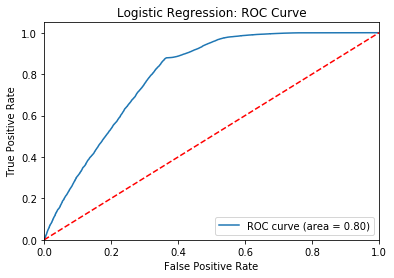

In [100]:
results = predict_test_LR.select(['probability', 'is_churn'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
mplt.figure()
mplt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
mplt.plot([0, 1], [0, 1], 'r--')
mplt.xlim([0.0, 1.0])
mplt.ylim([0.0, 1.05])
mplt.xlabel('False Positive Rate')
mplt.ylabel('True Positive Rate')
mplt.title('Logistic Regression: ROC Curve')
mplt.legend(loc="lower right")
mplt.show()

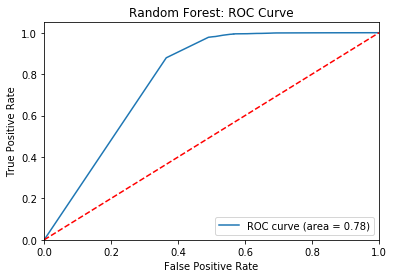

In [92]:

results = predict_test_RF.select(['probability', 'is_churn'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
mplt.figure()
mplt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
mplt.plot([0, 1], [0, 1], 'r--')
mplt.xlim([0.0, 1.0])
mplt.ylim([0.0, 1.05])
mplt.xlabel('False Positive Rate')
mplt.ylabel('True Positive Rate')
mplt.title('Random Forest: ROC Curve')
mplt.legend(loc="lower right")
mplt.show()

#Ref:https://weiminwang.blog/2016/06/09/pyspark-tutorial-building-a-random-forest-binary-classifier-on-unbalanced-dataset/


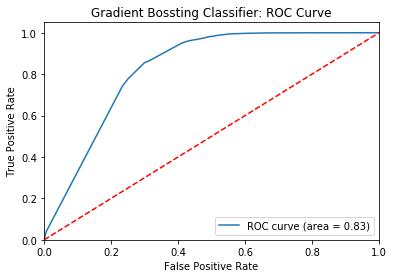

In [99]:
results = prediction.select(['probability', 'is_churn'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
mplt.figure()
mplt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
mplt.plot([0, 1], [0, 1], 'r--')
mplt.xlim([0.0, 1.0])
mplt.ylim([0.0, 1.05])
mplt.xlabel('False Positive Rate')
mplt.ylabel('True Positive Rate')
mplt.title('Gradient Bossting Classifier: ROC Curve')
mplt.legend(loc="lower right")
mplt.show()

Overall, Random forest classifier is the model giving least accuracy whereas Logistic Regression gives the most.

### Unsupervised Learning: KMeans Clustering:

In [40]:
kmeandf = churn_data.drop("features")
vecAssembler = VectorAssembler(inputCols=["Total25", "Total100","is_auto_renew","is_churn","is_cancel","bd","DaysOnBoard", "Discount","gender_indexed","payment_method_id", "payment_plan_days"], outputCol="features")
new_df = vecAssembler.transform(kmeandf)
new_df.show()


+--------------------+---------------+-------+--------+------------------+------------------+-----------------+-----------------+-------------+----------------+---------+--------+----+---+--------------+-----------+--------+--------------+--------------------+
|                msno|no_transactions|Total25|Total100|       UniqueSongs|     TotalSecHeard|payment_method_id|payment_plan_days|is_auto_renew|transaction_date|is_cancel|is_churn|city| bd|registered_via|DaysOnBoard|Discount|gender_indexed|            features|
+--------------------+---------------+-------+--------+------------------+------------------+-----------------+-----------------+-------------+----------------+---------+--------+----+---+--------------+-----------+--------+--------------+--------------------+
|+/namlXq+u3izRjHC...|             23|    970|      20|30.217391304347824| 72.30434782608695|               34|               30|            1|      2017-03-31|        0|       0|  15| 31|             9|       3984|  

In [48]:
from pyspark.ml.clustering import KMeans

cost = np.zeros(20)
for i in range(2,20):
    kmeans = KMeans(k=i, seed=1)  # 4 clusters here
    modelKMean = kmeans.fit(new_df.select("features"))
    cost[i] = modelKMean.computeCost(new_df) 
    
#ref: https://rsandstroem.github.io/sparkkmeans.html

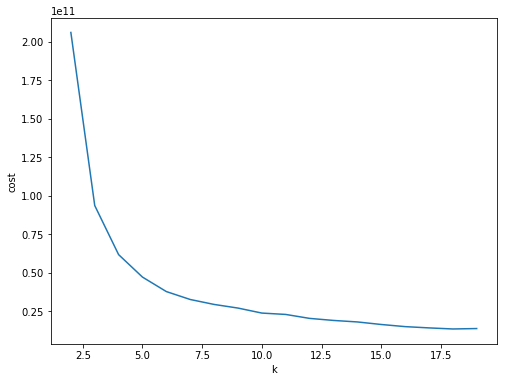

In [49]:
fig, ax = mplt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
mplt.show()

From the above graph , it can be seen that after k = 12, there is very little gain, hence sticking to k=12

In [51]:
kmeans = KMeans(k=12, seed=1)  
modelKMean = kmeans.fit(new_df.select("features"))

centers = modelKMean.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[  1.09801287e+02   2.08114797e+01   9.22934563e-01   8.22859984e-02
   2.03850510e-02   3.24597409e+01   3.60162470e+03  -5.30839986e-01
   4.81313703e-01   3.64825843e+01   3.50025412e+01]
[  1.13767598e+02   2.31480451e+01   7.73000120e-01   1.37920685e-01
   3.09736284e-02   2.72933291e+01   9.53703750e+02  -1.12677578e+00
   5.52823242e-01   3.72234983e+01   4.22809836e+01]
[  1.10628029e+03   9.10953284e+01   6.50225279e-01   1.40621295e-01
   2.34764050e-02   2.46400285e+01   9.98744368e+02  -1.68603272e+00
   5.81456011e-01   3.66011382e+01   4.26940953e+01]
[  1.25776375e+02   2.12191317e+01   7.40502570e-01   1.46690426e-01
   3.90744041e-02   2.71817618e+01   2.13973141e+02  -3.75938121e+00
   5.31546189e-01   3.62123654e+01   3.65901449e+01]
[  1.11034466e+02   2.16467104e+01   8.63239226e-01   1.15104782e-01
   2.88694733e-02   2.84806915e+01   1.40339932e+03  -4.77053666e-01
   5.38352714e-01   3.80313880e+01   3.79077949e+01]
[  1.15413410e+02   2.18653

In [53]:
transformed = modelKMean.transform(new_df)
transformed.describe()

DataFrame[summary: string, msno: string, no_transactions: string, Total25: string, Total100: string, UniqueSongs: string, TotalSecHeard: string, payment_method_id: string, payment_plan_days: string, is_auto_renew: string, transaction_date: string, is_cancel: string, is_churn: string, city: string, bd: string, registered_via: string, DaysOnBoard: string, Discount: string, gender_indexed: string, prediction: string]

In [55]:
cluster_dataset = transformed.drop('no_transactions','UniqueSongs','TotalSecHeard','msno', 'features','summary')
cluster_dataset.show()

+-------+--------+-----------------+-----------------+-------------+----------------+---------+--------+----+---+--------------+-----------+--------+--------------+----------+
|Total25|Total100|payment_method_id|payment_plan_days|is_auto_renew|transaction_date|is_cancel|is_churn|city| bd|registered_via|DaysOnBoard|Discount|gender_indexed|prediction|
+-------+--------+-----------------+-----------------+-------------+----------------+---------+--------+----+---+--------------+-----------+--------+--------------+----------+
|    970|      20|               34|               30|            1|      2017-03-31|        0|       0|  15| 31|             9|       3984|       0|           0.0|         9|
|    345|      31|               34|               30|            1|      2017-03-31|        0|       0|   9| 31|             9|       4779|       0|           0.0|        11|
|    100|      14|               34|               30|            1|      2017-03-31|        0|       0|  15| 29|       

In [56]:
#Number of points in each cluster
cluster_dataset.groupBy('prediction').count().show()


+----------+-----+
|prediction|count|
+----------+-----+
|         1|49987|
|         6|51424|
|         3|38723|
|         5|57577|
|         9|27209|
|         4|64331|
|         8|26315|
|         7|29570|
|        10|44764|
|        11|14163|
|         2| 4200|
|         0|36212|
+----------+-----+



In [78]:
cluster_dataset.filter("is_churn =='1'").groupby("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 6891|
|         6| 7193|
|         3| 5681|
|         5| 6543|
|         9| 2248|
|         4| 7406|
|         8| 2363|
|         7| 4206|
|        10| 5722|
|        11| 1798|
|         2|  592|
|         0| 2986|
+----------+-----+



In [85]:
import pyspark.sql.functions as F

df1 = cluster_dataset.groupBy('prediction').count().alias("Numppl")
df2 = cluster_dataset.filter("is_churn =='1'").groupby("prediction").count().alias("churncount")
inner_join = df1.join(df2, df1.prediction == df2.prediction).withColumn("ChurnPer", (100*(F.col("churncount.count") / F.col("Numppl.count"))))
inner_join.show()

+----------+-----+----------+-----+------------------+
|prediction|count|prediction|count|          ChurnPer|
+----------+-----+----------+-----+------------------+
|         1|49987|         1| 6891|13.785584251905494|
|         6|51424|         6| 7193|13.987632233976354|
|         3|38723|         3| 5681| 14.67086744312166|
|         5|57577|         5| 6543|11.363912673463362|
|         9|27209|         9| 2248| 8.261972141570805|
|         4|64331|         4| 7406|11.512334644261708|
|         8|26315|         8| 2363| 8.979669390081703|
|         7|29570|         7| 4206|14.223875549543456|
|        10|44764|        10| 5722| 12.78259315521401|
|        11|14163|        11| 1798|12.695050483654594|
|         2| 4200|         2|  592|14.095238095238095|
|         0|36212|         0| 2986|  8.24588534187562|
+----------+-----+----------+-----+------------------+



**Cluster Analysis**

We have analyzed the high and low value customers by studying the clusters 1, 5 and 6. 
We chose these clusters as we are interested in analyzing the larger population, accordingly these clusters have large number of customers as compared to the other clusters.

1. We can see that cluster 1 and 6 has high amount of churn (~14%) with respect to the total number of people in it (49987 and 51424). These are in the RED CATEGORY - High probability to churn.
2. We can see that cluster 5 has less amount of churn (~11%) with respect to the total number of people in it(57577).These are the GREEN CATEGORY as these are high value customers with lowest probability of churn.

## Recommendations And Conclusion

1. High value customers had less number of auto renewals. Hence we recommend the KKBox marketing team to focus on manually renewing the subscriptions or getting them on the auto renewal subscription plan. 
2. Most of the customers were between 27-30 age group. These were the active customers and the KKBox teams should focus on marketing and updating the application based on the general requirements in this age group.
3. The low value customers in RED CATEGORY should be given more discount to stop the churning.
4. It is observed that even with high churning, large number of these customers complete listening the entire songs. They should be constantly recommended their most heard songs and similar songs to stop them from churning.
5. We see from the discount feature that KKBOX offers less discount to its customers, and hence to retain its existing happy customers and the ones in the red category, we believe that more offers and discounts should be given.